# Trabajo con imágenes

Por:

* Fernando Gómez Perera - 160300129@ucaribe.edu.mx
* Ricardo Vargas Kumul- 170300227@ucaribe.edu.mx
* Calvin López Álvarez - 170300226@ucaribe.edu.mx

In [1]:
# Bibliotecas a usar
import os
import re
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

 Se definen algunas funciones auxiliares usadas en distintas partes del proceso.

In [2]:
# Leer una imagen para importarla al entorno
def read_img(img_path):
    with open(img_path, 'r') as img:
        img = cv.imread(img_path)
        # Regresar la imagen en escala de grises
        return cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Obtener una imagen binarizada a partir de otra mostrando una región específica seleccionada
def get_region(img, region=('bg', 'max', 'min')):
    # Ejecutar un análisis de componentes conectadas para extraer los objetos de la imagen
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(img, connectivity=4, ltype=cv.CV_16U)
    # Índices de todos los objetos encontrados
    objects = np.arange(num_labels)
    # Extraer el objeto más grande (con área mayor)
    max_object = np.argmax(stats[1::, 4]) + 1
    # Extraer la imagen binarizada elegida
    if region == 'max':
        return np.isin(labels, max_object).astype(np.uint8)
    elif region == 'min':
        # Extraer los objetos más pequeños
        min_objects = np.ma.array(objects[1:], mask=False)
        min_objects.mask[max_object - 1] = True
        min_objects = min_objects.compressed()
        return np.isin(labels, min_objects).astype(np.uint8)
    elif region == 'bg':
        # Extraer el fondo, incluyendo los objetos más pequeños
        bg = np.ma.array(objects, mask=False)
        bg.mask[max_object] = True
        bg = bg.compressed()
        return np.isin(labels, bg).astype(np.uint8)

## Artículos a replicar

Los artículos que usamos como referencia para desarrollar los proyectos son los siguientes:

* ***An improved GVF snake based breast region extrapolation scheme for digital mammograms*** de *Liu et al*.: El objetivo de este artículo es extrapolar la región del busto usando un esquema mejorado de una serpiente Flujo del Vector Gradiente o *Gradient Vector Flow (GVF) snake*.
*  ***A pectoral muscle segmentation algorithm for digital mammograms using Otsu thresholding and multiple regression analysis*** de *Liu et al*: El objetivo de este artículo es segmentar la región del músculo pectoral de la región del pecho combinando el esquema de umbralización de Otsu y el procesamiento matemático morfológico para obtener un borde del músculo pectoral, y usar el análsis de regresión múltiple (*MRA*) para obtener una segmentación precisa del mismo.

### Primer artículo: Extrapolación de la región del busto usando *GVF Snake*

Para llevarlo a cabo, tomamos como referencia el primer artículo de *Liu et al*. [[1]](#ref) En este artículo, los autores proponen un esquema mejorado de una serpiente Flujo del Vector Gradiente o *Gradient Vector Flow (GVF) snake* para poder extrapolar toda la región del busto. El esquema o algoritmo que ellos proponen es el siguiente:

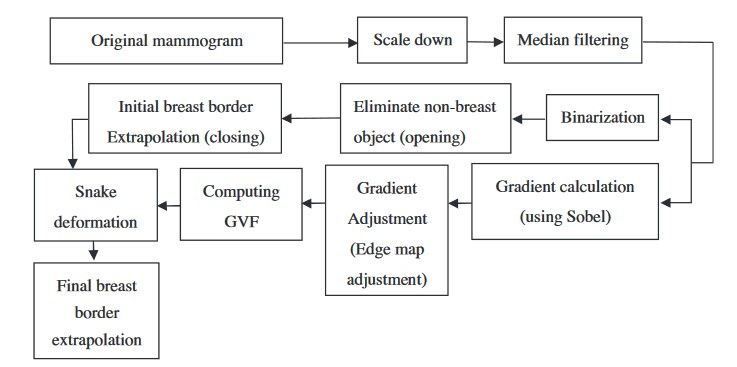

1. Reescalar las imágenes originales de las mamografías.
2. Aplicar un filtro de mediana a las imágenes reescaladas.

En este punto, el proceso se divide en 2 fases:

3. Binarizar la imagen reescalada.
4. Eliminar los objetos que no son de la región del busto.
5. Obtener une extrapolación inicial del borde del busto.

Paralelamente:

3. Aplicar un filtro de Sobel para obtener el campo gradiente de la mamografía reescalada.
4. Ajustar el campo gradiente.
5. Calcular el Flujo del Vector Gradiente (*GVF*).

En este punto, ambos procesos se unen:

6. Aplicar la deformación de la serpiente usando el *GVF* calculado sobre la extrapolación inicial del borde del busto.
7. Obtener la extrapolación final del borde del busto.

### Segunda artículo: Segmentación del músculo pectoral

## Tarea 1

### 2. Replica un proceso de limpieza del fondo de la imagen

Este proceso sigue la primera ramificación del algoritmo propuesto en el primer artículo.

Primero, se importan al entorno todas las imágenes originales.

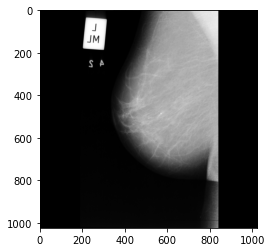

In [3]:
# Ruta de las imágenes originales
base_dir = '../extdata/all-mias/'
all_filenames = os.listdir(base_dir)
imgs_filenames = list()

# Extraer los archivos que corresponden a las imágenes de las mamografías
for filename in all_filenames:
    if filename.endswith('.pgm'):
        imgs_filenames.append(filename)
        
# Reordernar las imágenes alfabéticamente/numéricamente
imgs_filenames.sort()

# Lectura de las imágenes con el parámetro -1 para leer la imagen sin modificar
imgs_orig = list(map(lambda img_filename: read_img(base_dir+img_filename), imgs_filenames))

# Imagen de ejemplo
plt.imshow(imgs_orig[10], cmap='gray')
plt.show()

El artículo tiene varias partes que se contradicen entre sí. Al principio del artículo, los autores mencionan que **primero** se aplica el filtro de mediana sobre las mamografías originales y **después** el reescalamiento de las mamografías. Sin embargo, en el primer diagrama de flujo se puede notar que estos pasos están invertidos.

Hemos probado ambas formas, y llegamos a la conclusión que se obtienen mejores resultados si **primero** se aplica el filtro de mediana y **después** el reescalamiento de las imágenes. Así que estos pasos se llevan a cabo en ese orden.

#### 2.1 Aplicar el filtro de mediana

Los autores sugieren aplicar un filtro de mediana de 3 x 3 pixeles para reducir el ruido de la imagen.

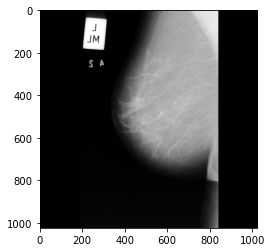

In [4]:
# Aplicar un filtro de mediana a cada una de las imágenes
imgs_filter = list(map(lambda img_orig: cv.medianBlur(img_orig, 3), imgs_orig))

# Imagen de ejemplo
plt.imshow(imgs_filter[10], cmap='gray')
plt.show()

#### 2.2 Reescalar la imagen

Las mamografías se reescalan para hacerlas más pequeñas. Esto permitirá ahorrar tiempo en la ejecución del resto del proceso.

Para mantener la calidad de la extrapolación, los autores sugieren reescalar las imágenes originales de 1024 x 1024 pixeles a 256 x 256 pixeles.

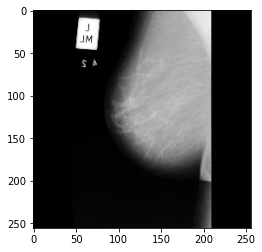

In [5]:
# Reescalar las imágenes para hacerlas más pequeñas (scale down)
imgs_scale = list(map(lambda img_filter: cv.resize(img_filter, (256, 256)), imgs_filter))

# Imagen de ejemplo
plt.imshow(imgs_scale[10], cmap='gray')
plt.show()

#### 2.3 Binarización de las imágenes

Este paso permite obtener un contorno aproximado. Para ello, los autores proponen obtener un umbrarl $T$, el cual será equivalente al valor medio de gris de la imagen.

La fórmula para calcular el umbral $T$ es la siguiente:

$$T = 0.2 \cdot  \frac{\sum_{n = 0}^{255} n \cdot H(n)}{\sum_{n = 0}^{255} H(n)}$$

donde $n$ es el valor del nivel de gris, el cual va de 0 a 255, y $H(n)$ es el número de pixeles con el valor de pixel $n$ dentro de la imagen, el cual se obtiene de su histograma.

Para binarizarla, se sigue la siguiente fórmula:

$$
\text{IB}(x, y)  = \begin{cases}
    1,\text{ si } I(x,y) \geq T,\\
    0, \text{ de otra forma}.
  \end{cases}
$$

donde $I(x, y)$ es el valor de intensidad de cada pixel en la imagen.

De esta forma, la imagen quedará divida en la región de fondo (con valor de pixel 0) y la región de objetos (con valor de pixel 1).

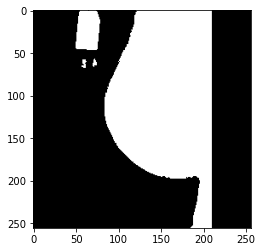

In [6]:
# Obtener del umbral a partir del valor del nivel de gris en la imagen
def T(img):
    H_n = cv.calcHist([img], [0], None, histSize=[256], ranges=(0, 256), accumulate=False).ravel()
    return 0.2 * np.sum(np.arange(0, 256) * H_n) / np.sum(H_n)

# Binarizar la imagen
def binarization(img):
    return np.where(img >= T(img), 1, 0).astype(np.uint8)

# Binarización de las imágenes
imgs_bin = list(map(lambda img_scale: binarization(img_scale), imgs_scale))

# Imagen de ejemplo
plt.imshow(imgs_bin[10], cmap='gray')
plt.show()

#### 2.4 Eliminar los objetos que no son parte de la región del busto.

Este proceso está compuesto de 2 partes:

##### 2.4.1 Procesamiento morfológico

Tomando como base el ejemplo de la imagen binarizada, se puede notar que además de la región del busto, hay pequeñas regiones que no son de interés. Para eliminarlos, los autores proponen en su algoritmo aplicar la operación morfológica de apertura, la cual está compuesta de 2 transformaciones morfológicas:

* La **erosión**, la cual, como dice su nombre, erosiona los límites del objeto en primer plano (siempre trata de mantener el primer plano en blanco).
* La **dilatación**, que es lo opuesto a la erosión. Esto provoca que aumente la región blanca en la imagen o aumente el tamaño del objeto en primer plano.

Para ello, la función toma un kernel que se desliza por la imagen, y modfica el valor de un pixel de acuerdo con los siguientes criterios:

* En el caso de la **erosión**, el valor del pixel será de 1 solamente si todos los pixeles bajo el kernel son 1. Sino, se erosiona (se vuelve 0).
* En el caso de la **dilatación**, el valor del pixel será de 1 si al menos un pixel bajo el kernel es de 1.

Los autores proponen usar un elemento estructurado (kernel) formado por un disco de radio 2 pixeles.

In [7]:
# Creación del kernel compuesto por un disco de radio 2
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
kernel[[1, 1, 3, 3], [0, 4, 0, 4]] = 0
kernel

array([[0, 0, 1, 0, 0],
       [0, 1, 1, 1, 0],
       [1, 1, 1, 1, 1],
       [0, 1, 1, 1, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

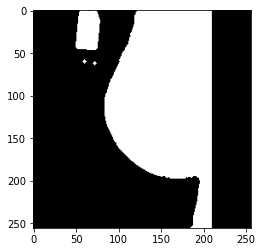

In [8]:
# Aplicar el procesamiento morfológico de apertura sobre las imágenes binarizadas
imgs_mpo = list(map(lambda img_bin: cv.morphologyEx(img_bin, cv.MORPH_OPEN, kernel), imgs_bin))

# Imagen de ejemplo
plt.imshow(imgs_mpo[10], cmap='gray')
plt.show()

##### 2.4.2 Extracción de la región del busto

Aún después de aplicar el procesamiento morfológico, y como se visualiza en la imagen de ejemplo, quedan todavía elementos que no corresponden al área del busto. Sin embargo, claramente se puede notar que su tamaño es menor en comparación a esta área.

Por ello, para eliminar los elementos faltantes, los autores proponen usar las características del objeto busto en la imagen mamográfica para etiquetar los objetos, y después extraer el objeto de mayor tamaño de la imagen binarizada. Y aquellos objetos que no correspondan al área del busto se modifican para volverse parte del fondo en dicha imagen. Finalmente, estos objetos también se modifican en la imagen reducida $I$, estableciendo sus valores de intensidad igual al nivel de gris medio del área que no pertenece al área del busto en ella.

Sin embargo, los autores no explican cómo llevaron a cabo este proceso. Por lo que nosotros implementamos un proceso que busca replicar los puntos que ellos mencionan.

Este proceso se compone de los siguientes pasos, aplicados a cada mamografía:

1. Obtener la región del fondo de la imagen binarizada procesada con la operación morfológica de apertura, que es equivalente a la región que no es del busto.
2. Obtener las intensidades de esta región, y calcular su nivel de gris medio
3. Modificar las intensidades de los objetos más pequeños detectados en la imagen binarizada original con el valor del nivel de gris medio en la imagen escalada.
4. Obtener la región del busto, que resulta ser la región más grande dentro de la imagen binarizada procesada con la operación morfológica de apertura.
5. Regresar la imagen escalada limpia y la imagen binarizada limpia.

In [9]:
# Extraer la región del busto
def extract_breast_region(img_scale, img_bin, img_mpo):
    # Obtener la región que no pertenece a la región del busto
    bg_region = get_region(img_mpo, region='bg')
    # Obtener las intensidades de la región que no pertenece a la región del busto
    bg_values = np.ma.array(img_scale, mask=False)
    bg_values.mask = np.where(bg_region == 1, False, True)
    # Calcular el nivel de gris medio de estas áreas
    mean_gray_level = np.mean(bg_values)
    # Modificar las intensidades en los objetos más pequeños
    smaller_objects = get_region(img_mpo, region='bg')
    mod_img_scale = np.where(smaller_objects == 1, mean_gray_level, img_scale).astype(np.uint8)
    # Obtener la región más grande, que corresponde a la región del busto
    breast_region = get_region(img_mpo, region='max')
    return mod_img_scale, breast_region

In [10]:
# Eliminar los objetos que no son parte de la región del busto en las imágenes escaladas
imgs_clean = list()
imgs_bin_clean = list()

for img_scale, img_bin, img_mpo in zip(imgs_scale, imgs_bin, imgs_mpo):
    img_clean, img_bin_clean = extract_breast_region(img_scale, img_bin, img_mpo)
    imgs_clean.append(img_clean)
    imgs_bin_clean.append(img_bin_clean)

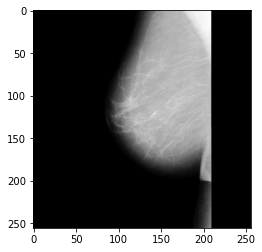

In [11]:
# Imagen de ejemplo (Imagen escalada limpia)
plt.imshow(imgs_clean[10], cmap='gray')
plt.show()

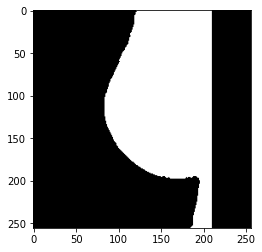

In [12]:
# Imagen de ejemplo (Imagen binarizada limpia)
plt.imshow(imgs_bin_clean[10], cmap='gray')
plt.show()

Finalmente, todas las imágenes limpias se almacenan en el directorio de la aplicación para que puedan usarse dentro de ella.

In [13]:
# Almacenar las mamografías limpias en la carpeta de la aplicación
app_dir = '../app/img/'
# Obtener los números de imagen en el orden en el que se importaron al entorno
find_nums = re.compile('\d{3}')
imgs_nums = list(map(lambda filename: int(find_nums.findall(filename)[0]), imgs_filenames))

for img_scale, img_clean, img_bin_clean, img_num in zip(imgs_scale, imgs_clean, imgs_bin_clean, imgs_nums):
    cv.imwrite(app_dir + str(img_num) + '_scale.png', img_scale)
    cv.imwrite(app_dir + str(img_num) + '_clean.png', img_clean)
    cv.imwrite(app_dir + str(img_num) + '_bin_clean.png', np.where(img_bin_clean == 1, 255, 0))

## Tarea 2

### 3. Replica un proceso que elimine el músculo pectoral

Antes de llevar a cabo el proceso de eliminación del músculo pectoral, es necesario terminar de extraer el contorno de la región del busto siguiendo el diagrama de flujo del punto anterior.

#### 3.1 Obtener el contorno final de la región del busto usando *GVF Snake*

##### 3.1.1 Extraer el contorno inicial de la región del busto

El siguiente paso es extraer el contorno inicial de la región del busto usando la siguiente fórmula:

$$\text{IB}_{\text{edge}} = \text{IB}_{\text{fin}} - \text{IB}_{\text{ero}}$$

Donde $\text{IB}_{\text{fin}}$ es la imagen binarizada limpia obtenida en el paso anterior, e $\text{IB}_{\text{ero}}$ es la imagen resultante de aplicar la operación de erosión morfológica sobre  $\text{IB}_{\text{fin}}$.

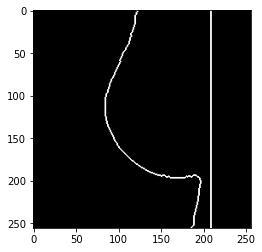

In [14]:
# Extrapolación inicial del borde de la región del busto
def extract_initial_breast_border(img_bin_clean, erode_iterations=1):
    return img_bin_clean - cv.erode(img_bin_clean, kernel, iterations=erode_iterations)

# Obtener la extrapolación inicial del borde de la región del busto de las imágenes binarizadas limpias
imgs_edges = list(map(lambda img_bin_clean: extract_initial_breast_border(img_bin_clean, erode_iterations=1), imgs_bin_clean))

# Imagen de ejemplo
plt.imshow(imgs_edges[10], cmap='gray')
plt.show()

#####  3.1.2 Cálculo del gradiente usando el filtro de Sobel

Para poder aplicar el *GVF Snake*, primero es necesario obtener el gradiente de los pixeles de cada imagen limpia usando el filtro de Sobel.

El filtro de Sobel sigue la fórmula:

$$G(x, y) = |G_x(x, y)| + |G_y(x, y)|$$

donde $G_x(x, y)$ y $G_y(x, y)$ indican los cambios en la componente horizontal y vertical del pixel en la posición $(x, y) $ de cada imagen.

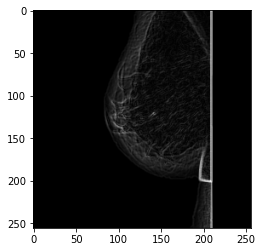

In [109]:
# Calcular el gradiente de los pixeles de una imagen usando el filtro de Sobel
def Sobel_filter(img):
    # Cálculo de los gradientes de cada componente
    grad_x = cv.Sobel(img, cv.CV_64F, dx=1, dy=0)
    grad_y = cv.Sobel(img, cv.CV_64F, dx=0, dy=1)
    # Convertir los valores de las componentes a su valor absoluto
    abs_grad_x = cv.convertScaleAbs(grad_x)
    abs_grad_y = cv.convertScaleAbs(grad_y)
    # Calcular el gradiente usando la fórmula del filtro de Sobel
    grad = cv.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    return abs_grad_x, abs_grad_y, grad

# Calcular el gradiente de cada imagen y sus componentes
imgs_grad_x = list()
imgs_grad_y = list()
imgs_grad = list()

for img_clean in imgs_clean:
    grad_x, grad_y, grad = Sobel_filter(img_clean)
    imgs_grad_x.append(grad_x)
    imgs_grad_y.append(grad_y)
    imgs_grad.append(grad)

# Imagen de ejemplo
plt.imshow(imgs_grad[10], cmap='gray')
plt.show()

In [106]:
grad[10].max()

128

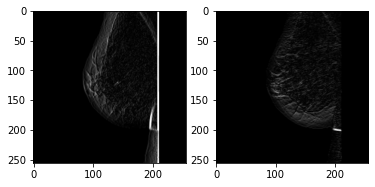

In [112]:
plt.subplot(121)
plt.imshow(imgs_grad_x[10], cmap='gray')
plt.subplot(122)
plt.imshow(imgs_grad_y[10], cmap='gray')
plt.show()

#####  3.1.2 Ajuste del gradiente

Los autores proponen una operación de ajuste sobre el gradiente obtenido en el paso anterior, pues mencionan que aplicar *GVF Snake* directamente sobre el gradiente podría tener como resultado un borde de la región del busto malo. La fórmula que ellos proponen es la siguiente:

$$G_\text{adjust}(x, y) = w_0 \cdot \frac{G(x, y) - G_\text{min}}{G_\text{max} - G_\text{min}} + w_1 \cdot \frac{T - I(x, y)}{255}$$

Donde:
* $w_0$ y $w_1$ son pesos asignados por el usuario, los cuales toman los valores $0 \leq w_0 \leq 1$ y $w_1 = 1 - w_0$ (los autores mencionan que $w_0  = 0.63$ y que este dato es experimental).
* $G_\text{max}$ y $G_\text{min}$ son el valor máximo y mínimo de la magnitud del campo gradiente $G$, respectivamente.
* $T$ es el umbral obtenido el paso 2.3.
* $I(x, y)$ es la imagen limpia.

Según los autores, esta operación debería tener como resultado una imagen donde cada pixel adquiere un valor entre 0 y 1, y que esto debería ayudar a que el borde del busto se acerque más al borde real, pues esta operación disminuye el gradiente relativo de la región clara y aumenta el gradiente relativo de la región oscura.

Sin embargo, al replicar esta operación, nosotros obtuvimos valores negativos, los cuales no se ajustan a lo que mencionan los autores, y afectan fuertemente los resultados obtenido más adelante. Un ejemplo se muestra a continuación:

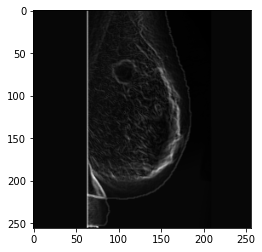

array([ 0.00516818,  0.00516818,  0.00516818,  0.00516818,  0.00516818,
        0.00516818,  0.00516818,  0.00516818,  0.00516818,  0.00516818,
        0.00516818,  0.00516818,  0.00516818,  0.00516818,  0.00516818,
        0.00516818,  0.00516818,  0.00516818,  0.00516818,  0.00516818,
        0.00516818,  0.00516818,  0.00516818,  0.00516818,  0.00516818,
        0.00516818,  0.00516818,  0.00516818,  0.00516818,  0.00516818,
        0.00516818,  0.00516818,  0.00516818,  0.00516818,  0.00516818,
        0.00516818,  0.00516818,  0.00516818,  0.00516818,  0.00516818,
        0.00516818,  0.00516818,  0.00516818,  0.00516818,  0.00516818,
        0.00516818,  0.00516818,  0.00516818,  0.00516818,  0.00516818,
        0.00516818,  0.00516818,  0.00516818,  0.00516818,  0.00516818,
        0.00516818,  0.00516818,  0.00516818,  0.00516818,  0.00516818,
        0.00516818,  0.00516818,  0.00516818,  5.10282443,  5.10282443,
        0.04499362,  0.04499362,  0.04499362,  0.04499362,  0.04

In [120]:
# Ajuste del gradiente sobre una imagen de muestra
test_img = imgs_clean[10].copy()
w0 = 0.63
w1 = 1 - w0
grad_magn = np.sqrt(np.power(grad_x, 2) + np.power(grad_y, 2))

grad_adjust = w0 * ((grad - np.min(grad_magn)) / (np.max(grad_magn) - np.min(grad_magn))) + w1 * ((T(test_img) - test_img) / 255)

# Valor mínimo obtenido de esta operación
plt.imshow(grad_adjust, cmap='gray')
plt.show()
grad_adjust[0]

Como los autores no mencionan nada sobre cómo manejar estos valores negativos, decidimos usar el gradiente obtenido del filtro de Sobel para aplicar el *GVF Snake*.

#####  3.1.3 Aplicar *GVF Snake*

Primero resulta conveniente explicar un poco el concepto de *serpiente* en este contexto.

###### Serpientes clásicas en la segmentación de imágenes

Llamadas también como *modelo activo del contorno*, permite obtener una curva deformable en el dominio espacial de la imagen minimizando una función de energía. La forma de la serpiente es modificada por las fuerzas internas que intentan mantener la suavidad de la forma de la serpiente, y también es modificada por las fuerzas externas que atraen a la serpiente hacia las característica destacadas de la imagen.

Este modelo tiene 2 incovenientes:

1. La serpiente inicial debe estar bastante cerca del límite verdadero.
2. El contorno activo no puede deformarse fácilmente en puntos de contorno cóncavos.

###### Serpiente *GVF*

Es una mejora del modelo clásico de serpíente., con el objetivo de obtener un mejor rendimiento en la segmentación de imágenes.

La idea detrás de este modelo es agrandar el rango de influencia de cada fuerza externa creando un campo del flujo del vector gradientepara sustituir el cambo de fuerzas externas de la serpiente clásica.

Este modelo mejora el rango restringido de captura y la débil convergencia de la serpiente clásica. Pero aún depende de la distribución del gradiente de la imagen.

La función de energía usada en el modelo del *GVF snake* es la siguiente:

$$\varepsilon = \int \int \mu (u_x^2 + u_y^2 + v_x^2 + v_y^2) + |\nabla f|^2 |V -  \nabla f|^2 dx dy$$

Donde:

* $\mu$ es un parámetro de regularización.
* $f(x, y)$ es un mapa de contornos.
* V es el campo del flujo del vector gradiente (*GVF*) tal que $V(x, y) = (u(x, y), v(x, y))$, el cual minimiza la función de energía.

El campo GVF se puede obtener resolviendo las siguientes ecuaciones de Euler-Lagrange:

$$\mu \nabla^2 u - (u - f_x)(f_x^2 + f_y^2) = 0$$

$$\mu \nabla^2 v -  (v - f_y)(f_x^2 + f_y^2) = 0$$

donde $\nabla^2$ es el operador Laplaciano.

Las ecuaciones anteriores se pueden resolver tratando $u$ y $v$ como funciones del tiempo:

$$u_t(x, y, t) = \mu \nabla^2 u(x, y, t)  - (u(x, y, t) - f_x(x, y) )(f_x(x, y) ^2 + f_y(x, y) ^2)$$

$$v_t(x, y, t) = \mu \nabla^2 v(x, y, t)  -  (v(x, y, t) - f_y(x, y) )(f_x(x, y) ^2 + f_y(x, y) ^2)$$

Finalmente, 

###### Modelo propuesto de la serpiente GVF

In [ ]:
# Operación del GVF Snake para obtener la región del busto
def gvf_snake(grad_x, grad_y, img_edge, )

In [47]:
fx = cv.Sobel(grad, cv.CV_64F, dx=1, dy=0)
fy = cv.Sobel(grad, cv.CV_64F, dx=0, dy=1)

u = fx.copy()
v = fy.copy()

lamb = 0.1

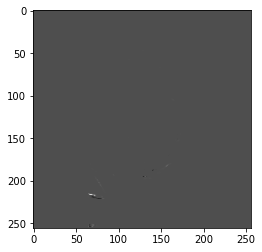

In [48]:
for i in range(5):
    u = lamb * cv.Laplacian(u, cv.CV_64F) - (u - fx) * (fx*+2 + fy**2)

for i in range(5):
    v = lamb * cv.Laplacian(v, cv.CV_64F) - (v - fy) * (fx*+2 + fy**2)
    
plt.imshow(u, cmap='gray')
plt.show()

In [ ]:
plt.imshow(v, cmap='gray')
plt.show()

In [ ]:
np.all(V == imgs_edges[10])

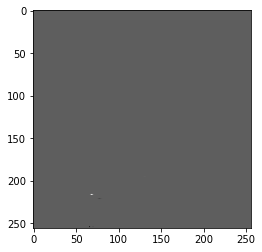

In [43]:
V = cv.addWeighted(u, 1, v, 1, 0)

plt.imshow(V, cmap='gray')
plt.show()

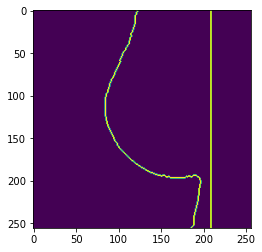

In [44]:
plt.imshow(imgs_edges[10])

In [45]:
X_s = imgs_edges[10].copy()
alpha = 0.001
beta = 0.001

for i in range(5):
    X_s_2 = cv.Laplacian(X_s, cv.CV_64F)
    X_s_4 = cv.Laplacian(X_s_2, cv.CV_64F)
    X_s = alpha * X_s_2 - beta * X_s_4 + V

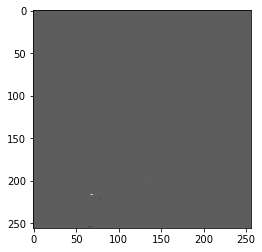

In [46]:
plt.imshow(X_s, cmap='gray')
plt.show()

In [ ]:
X = clean_imgs[10] + X_s

plt.imshow(X, cmap='gray')
plt.show()

In [ ]:
grad = cv.addWeighted(u, 0.5, v, 0.5, 0)

plt.imshow(grad, cmap='gray')
plt.show()

In [ ]:
x = img_test
alpha = 0.1
beta = 0.1

for i in range(20):
    x_1 = cv.Sobel(img_edges, cv.CV_16S, 1, 0, ksize=3, scale=1, delta=0, borderType=cv.BORDER_DEFAULT)
    y_1 = cv.Sobel(img_edges, cv.CV_16S, 0, 1, ksize=3, scale=1, delta=0, borderType=cv.BORDER_DEFAULT)
    
    x_1 = cv.convertScaleAbs(x_1)
    y_1 = cv.convertScaleAbs(y_1)
    
    grad = cv.addWeighted(x_1, 1, y_1, 1, 0)
    grad_2 = cv.Laplacian(img_edges, cv.CV_16S, 3)
    grad_2 = cv.convertScaleAbs(grad_2)
    
    x = alpha * grad_2 - beta * grad_2+grad
    
plt.imshow(x, cmap='gray')
plt.show()

In [ ]:
X = clean_imgs[10] + x

plt.imshow(X, cmap='gray')
plt.show()

In [ ]:
x

In [ ]:
?cv.threshold

In [ ]:
bin_x = cv.threshold(X.astype(np.uint8),0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)[1]

plt.imshow(bin_x, cmap='gray')
plt.show()

In [ ]:
x_mpo = cv.morphologyEx(bin_x, cv.MORPH_OPEN, kernel)

# Imagen de ejemplo
plt.imshow(x_mpo, cmap='gray')
plt.show()

In [ ]:
bin_x = cv.threshold(x_mpo,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)[1]
x_mpo = cv.morphologyEx(bin_x, cv.MORPH_OPEN, kernel)

plt.imshow(x_mpo, cmap='gray')
plt.show()

In [ ]:
bin_x = cv.threshold(x_mpo,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)[1]
x_mpo = cv.morphologyEx(bin_x, cv.MORPH_OPEN, kernel)

plt.imshow(x_mpo, cmap='gray')
plt.show()

In [ ]:
bin_x

In [15]:
?cv.Sobel

Docstring:
Sobel(src, ddepth, dx, dy[, dst[, ksize[, scale[, delta[, borderType]]]]]) -> dst
.   @brief Calculates the first, second, third, or mixed image derivatives using an extended Sobel operator.
.   
.   In all cases except one, the \f$\texttt{ksize} \times \texttt{ksize}\f$ separable kernel is used to
.   calculate the derivative. When \f$\texttt{ksize = 1}\f$, the \f$3 \times 1\f$ or \f$1 \times 3\f$
.   kernel is used (that is, no Gaussian smoothing is done). `ksize = 1` can only be used for the first
.   or the second x- or y- derivatives.
.   
.   There is also the special value `ksize = #CV_SCHARR (-1)` that corresponds to the \f$3\times3\f$ Scharr
.   filter that may give more accurate results than the \f$3\times3\f$ Sobel. The Scharr aperture is
.   
.   \f[\vecthreethree{-3}{0}{3}{-10}{0}{10}{-3}{0}{3}\f]
.   
.   for the x-derivative, or transposed for the y-derivative.
.   
.   The function calculates an image derivative by convolving the image with the appropriate ke

In [ ]:
# tamaño de la imagen
N = 256 * 256

# Sacamos el threshold de la imagen nuevmaente
threshold = T(clean_imgs[10])

# especificamos que trabajaremos sobre 'l'
l = sp.Symbol('l')

# valores minimos y maximos de la imagen
l_min = np.min(clean_imgs[10])
l_max = np.max(clean_imgs[10])

n_l = list(clean_img[10].flatten()).count(l)

w_1 = (1/N) * sp.integrate(n_l,(l,l_min,threshold))
w_2 = w_1 - 1

print(w_1)
print(w_2)

1. aplicar la binarizacion anterior con el nuevo threshold de obtenido con otsu
2. usar el mismo kernel de radio 2 pero con morphological opening (es una de las 4 transformaciones)
3. hacer lo mismo que en el anterior donde al original se le restaba el erosionado para obtener el nuevo

## 1

In [ ]:
# Aplicar un filtro gausiano a cada una de las imágenes
imgs_gauss = list(map(lambda clean_imgs: cv.GaussianBlur(clean_imgs, (5, 5), 0), clean_imgs))

# Imagen de ejemplo
plt.imshow(imgs_gauss[10], cmap='gray')
plt.show()

In [ ]:
def T_O(img):
    val, _ = cv.threshold(img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU,)
    return val

In [ ]:
T_O(test_img)

In [ ]:
test_img = clean_imgs[4]
plt.imshow(test_img, cmap = 'gray')

In [ ]:
# Binarizar la imagen
def binarization_otsu(img):
    return np.where(img >= T_O(img), 1, 0).astype(np.uint8)

# Binarización de las imágenes
#imgs_bin_gauss = list(map(lambda imgs_gauss: binarization_otsu(imgs_gauss), imgs_gauss))
otsu_img = cv.threshold(test_img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]

In [ ]:
img = test_img.copy()
thresh, otsu_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

for i in range(10):
    a = np.where(otsu_img == 1, img, 0).ravel()
    print(a[a >= 0])
    mean1 = np.mean(np.where(otsu_img == 1, img, 0))
    mean2 = np.mean(np.where(otsu_img == 0, img))
    plt.imshow(otsu_img, cmap='gray')
    plt.show()
    tbd_region = np.where(np.logical_and(img > mean1, img < mean2), img, 0)
    plt.imshow(tbd_region, cmap='gray')
    plt.show()
    thres, otsu_img = cv.threshold(tbd_region, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

In [ ]:
# Fer's Threshold + imagen
#print(T(imgs_gauss[10]))
plt.imshow(otsu_img, cmap='gray')
plt.show()

In [ ]:
# Aplicar el procesamiento morfológico de apertura sobre las imágenes binarizadas
#imgs_bin_gauss_mpo = list(map(lambda imgs_bin_gauss: cv.morphologyEx(imgs_bin_gauss, cv.MORPH_OPEN, kernel), imgs_bin_gauss))

mpo_img = cv.morphologyEx(otsu_img, cv.MORPH_OPEN, kernel)

# Imagen de ejemplo
plt.imshow(mpo_img, cmap='gray')
plt.show()

In [ ]:
output = cv.connectedComponentsWithStats(mpo_img, connectivity=4, ltype = cv.CV_32S)
(numLabels, labels, stats, centroids) = output

In [ ]:
output

In [ ]:
# loop over the number of unique connected component labels
for i in range(0, numLabels):
	# if this is the first component then we examine the
	# *background* (typically we would just ignore this
	# component in our loop)
	if i == 0:
		text = "examining component {}/{} (background)".format(
			i + 1, numLabels)

	# otherwise, we are examining an actual connected component
	else:
		text = "examining component {}/{}".format( i + 1, numLabels)

	# print a status message update for the current connected
	# component
	print("[INFO] {}".format(text))

	# extract the connected component statistics and centroid for
	# the current label
	x = stats[i, cv.CC_STAT_LEFT]
	y = stats[i, cv.CC_STAT_TOP]
	w = stats[i, cv.CC_STAT_WIDTH]
	h = stats[i, cv.CC_STAT_HEIGHT]
	area = stats[i, cv.CC_STAT_AREA]
	(cX, cY) = centroids[i]
    
    # clone our original image (so we can draw on it) and then draw
	# a bounding box surrounding the connected component along with
	# a circle corresponding to the centroid
	output = otsu_img.copy()
	cv.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)
	cv.circle(output, (int(cX), int(cY)), 4, (0, 0, 255), -1)
    
    # construct a mask for the current connected component by
	# finding a pixels in the labels array that have the current
	# connected component ID
	componentMask = (labels == i).astype("uint8") * 255

	# show our output image and connected component mask
	plt.imshow(output, cmap='gray')
	plt.show()
	plt.imshow(componentMask, cmap='gray')
	plt.show()

In [ ]:
mask = np.zeros(otsu_img.shape, dtype="uint8")

# loop over the number of unique connected component labels, skipping
# over the first label (as label zero is the background)
for i in range(1, 2):
	# extract the connected component statistics for the current
	# label
	x = stats[i, cv.CC_STAT_LEFT]
	y = stats[i, cv.CC_STAT_TOP]
	w = stats[i, cv.CC_STAT_WIDTH]
	h = stats[i, cv.CC_STAT_HEIGHT]
	area = stats[i, cv.CC_STAT_AREA]
	print(x, y, w, h, area)
    # construct a mask for the current connected component and
	# then take the bitwise OR with the mask
	print("[INFO] keeping connected component '{}'".format(i))
	componentMask = (labels == i).astype("uint8") * 255
	mask = cv.bitwise_or(mask, componentMask)
        

plt.imshow(mask, cmap = 'gray')

In [ ]:
test_img_2 = np.where(mask != 0, test_img, mask)
#test_img_2 = np.where(img_edges == 255, img_edges, test_img_2)

In [ ]:
plt.imshow(test_img_2, cmap='gray')
plt.show()

In [ ]:
otsu_img_2 = cv.threshold(test_img_2, 0, 255, type = cv.THRESH_BINARY + cv.THRESH_OTSU)[1]
mpo_img_2 = cv.morphologyEx(otsu_img_2, cv.MORPH_OPEN, kernel)

plt.imshow(mpo_img_2, cmap='gray')
plt.show()

In [ ]:
?cv.morphologyEx

In [ ]:
mask = np.zeros(mpo_img_2.shape, dtype="uint8")

# loop over the number of unique connected component labels, skipping
# over the first label (as label zero is the background)
for i in range(1, 2):
	# extract the connected component statistics for the current
	# label
	x = stats[i, cv.CC_STAT_LEFT]
	y = stats[i, cv.CC_STAT_TOP]
	w = stats[i, cv.CC_STAT_WIDTH]
	h = stats[i, cv.CC_STAT_HEIGHT]
	area = stats[i, cv.CC_STAT_AREA]
	print(x, y, w, h, area)
    # construct a mask for the current connected component and
	# then take the bitwise OR with the mask
	print("[INFO] keeping connected component '{}'".format(i))
	componentMask = (labels == i).astype("uint8") * 255
	mask = cv.bitwise_or(mask, componentMask)
        

plt.imshow(mask, cmap = 'gray')

In [ ]:
test_img_3 = np.where(mask != 0, test_img_2, mask).astype(np.uint8)

plt.imshow(test_img_3, cmap='gray')
plt.show()

In [ ]:
# find normalized_histogram, and its cumulative distribution functio
hist = cv.calcHist([test_img_3],[0],None,[256],[0,256])
hist_norm = hist.ravel()/hist.max()
Q = hist_norm.cumsum()
bins = np.arange(256)
fn_min = np.inf
thresh = -1
for i in range(1,256):
    p1,p2 = np.hsplit(hist_norm,[i]) # probabilities
    q1,q2 = Q[i],Q[255]-Q[i] # cum sum of classes
    if q1 == 0:
        q1 = 0.00000001
    if q2 == 0:
        q2 = 0.00000001
    b1,b2 = np.hsplit(bins,[i]) # weights
    # finding means and variances
    m1,m2 = np.sum(p1*b1)/q1, np.sum(p2*b2)/q2
    v1,v2 = np.sum(((b1-m1)**2)*p1)/q1,np.sum(((b2-m2)**2)*p2)/q2
    # calculates the minimization function
    fn = v1*q1 + v2*q2
    if fn < fn_min:
        fn_min = fn
        thresh = i
        
thresh

In [ ]:
np.histogram(test_img_3, bins=256, range=(0, 255))

In [ ]:
cv.threshold(test_img_3, 0, 1, cv.THRESH_BINARY)[1].max()

#plt.imshow(cv.threshold(test_img_3, 0, 1, cv.THRESH_BINARY)[1], cmap='gray')

In [ ]:
# Otsu's Threshold + imagen
print(T_O(imgs_gauss[10]))
plt.imshow(imgs_bin_gauss[10], cmap='gray')
plt.show()

In [ ]:
plt.imshow(imgs_bin_gauss_mpo[10], cmap='gray')
plt.show()

## <a name="ref"></a>  Referencias

Liu, C.-C., Tsai, C.-Y., Tsui, T.-S., & Yu, S.-S. (2012). An improved GVF snake based breast region extrapolation scheme for digital mammograms. Expert Systems with Applications, 39(4), 4505-4510. https://doi.org/10.1016/j.eswa.2011.09.136

Liu, C.-C., Tsai, C.-Y., Liu, J., Yu, C.-Y., & Yu, S.-S. (2012). A pectoral muscle segmentation algorithm for digital mammograms using Otsu thresholding and multiple regression analysis. Computers & Mathematics with Applications, 64(5), 1100-1107. https://doi.org/10.1016/j.camwa.2012.03.028

OpenCV. (2021, 9 marzo). OpenCV: Morphological Transformations. https://docs.opencv.org/master/d9/d61/tutorial_py_morphological_ops.html